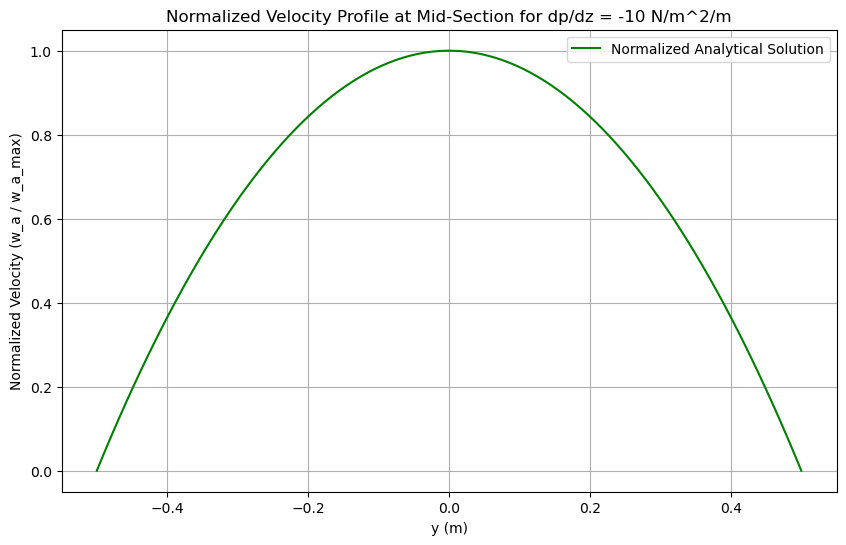

In [15]:
import numpy as np
import matplotlib.pyplot as plt
def analytical_solution(y, z, L, h, dp_dz, mu=0.4, terms=100):
    sum_series = np.zeros_like(y)
    for m in range(1, 2 * terms, 2):  # Sum over odd m: 1, 3, 5, ...
        z_factor = m * np.pi * z / (2 * L)
        h_factor = m * np.pi * h / (2 * L)

        # Compute the stable ratio of cosh terms
        if z_factor < h_factor:
            cosh_ratio = np.exp(z_factor - h_factor)
        else:
            cosh_ratio = np.exp(h_factor - z_factor)

        # Compute the series term
        term = ((-1)**((m-1)//2) *
                np.cos(m * np.pi * y / (2 * L)) / m**3) * (1 - cosh_ratio)
        sum_series += term
    return (16 * L**2 * (-dp_dz) / (mu * np.pi**3)) * sum_series
    

# Example usage
L = 1.5  # Length of the duct in meters
h = 1.0  # Height of the duct in meters
dp_dz = -10  # Pressure gradient in N/m^2/m
mu = 0.4  # Dynamic viscosity in Ns/m^2
z = L / 2  # Mid-section

# Define y-coordinates symmetrically around the center
y = np.linspace(-h/2, h/2, 100)

# Calculate the analytical solution
result = analytical_solution(y, z, L, h, dp_dz, mu, terms=200)
result_shifted = result - np.min(result)

 


# Normalize the velocity profile by the maximum velocity value
result_normalized = result_shifted / np.max(result_shifted)

# Plotting the normalized result
plt.figure(figsize=(10, 6))
plt.plot(y, result_normalized, label='Normalized Analytical Solution', color='green')
plt.title('Normalized Velocity Profile at Mid-Section for dp/dz = -10 N/m^2/m')
plt.xlabel('y (m)')
plt.ylabel('Normalized Velocity (w_a / w_a_max)')
plt.legend()
plt.grid(True)
plt.show()



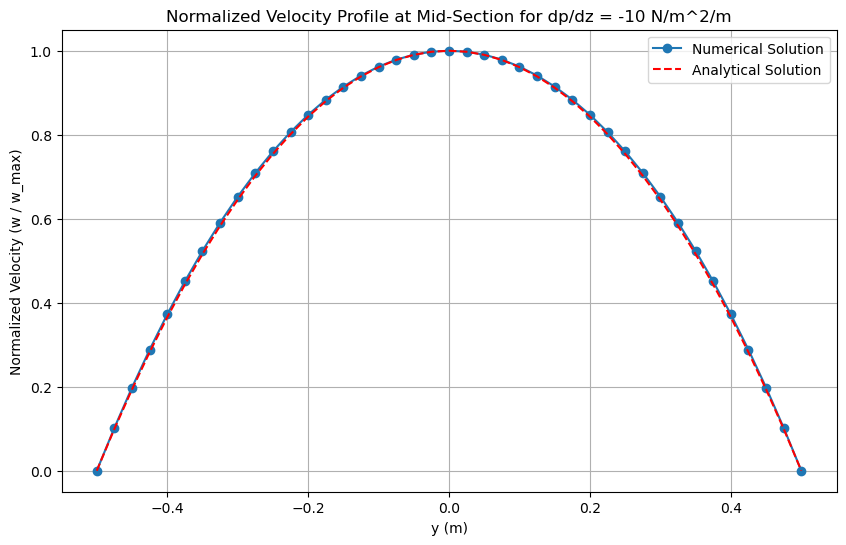

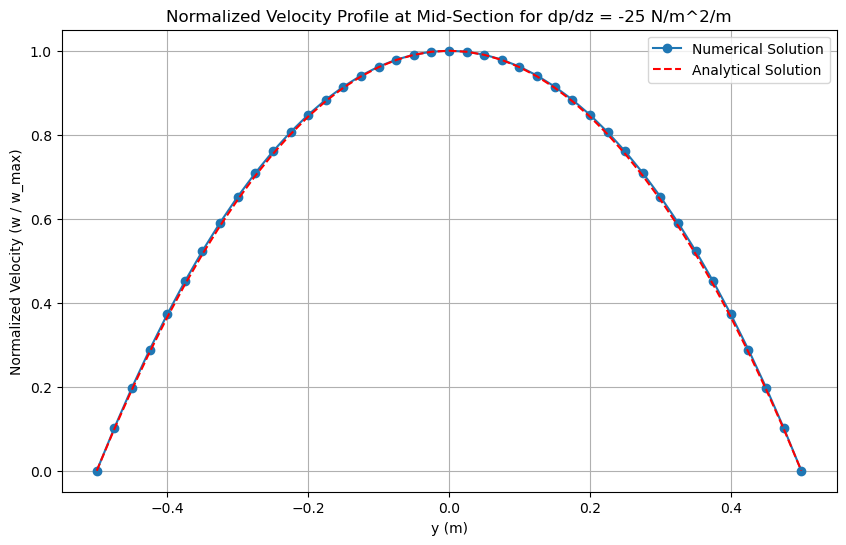

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit

# Constants
L = 1.5  # Length of the duct in meters
h = 1.0  # Height of the duct in meters
mu = 0.4  # Dynamic viscosity in Ns/m^2

# Grid parameters
JM = 41  # Grid points in x direction (along the length)
KM = 41  # Grid points in y direction (across the height)
dx = L / (JM - 1)  # Grid spacing in x-direction
dy = h / (KM - 1)  # Grid spacing in y-direction

# Initialize the grid
def initialize_grid(KM, JM):
    return np.zeros((KM, JM))

@njit
def sor(w, dx, dy, dp_dz, mu, tol, max_iterations, omega):
    KM, JM = w.shape
    for it in range(max_iterations):
        w_old = w.copy()
        for j in range(1, KM - 1):
            for i in range(1, JM - 1):
                w[j, i] = ((w[j, i + 1] + w[j, i - 1]) * dy**2 +
                           (w[j + 1, i] + w[j - 1, i]) * dx**2 +
                           dx**2 * dy**2 * dp_dz / mu) / (2 * (dx**2 + dy**2))
        if np.sqrt(np.mean((w - w_old) ** 2)) < tol:
            break
    return w

def analytical_solution(y, z, L, h, dp_dz, mu=0.4, terms=100):
    sum_series = np.zeros_like(y)
    for m in range(1, 2 * terms, 2):  # Sum over odd m: 1, 3, 5, ...
        z_factor = m * np.pi * z / (2 * L)
        h_factor = m * np.pi * h / (2 * L)

        # Compute the stable ratio of cosh terms
        if z_factor < h_factor:
            cosh_ratio = np.exp(z_factor - h_factor)
        else:
            cosh_ratio = np.exp(h_factor - z_factor)

        # Compute the series term
        term = ((-1)**((m-1)//2) *
                np.cos(m * np.pi * y / (2 * L)) / m**3) * (1 - cosh_ratio)
        sum_series += term
    return (16 * L**2 * (-dp_dz) / (mu * np.pi**3)) * sum_series

# Solver settings
dp_dz_values = [-10, -25]  # Pressure gradients
omega = 1.876  # Relaxation factor
tol = 0.00001
max_iterations = 10000

# Run simulation and plot for each pressure gradient
y = np.linspace(-h/2, h/2, KM)  # Centered y-coordinates
for dp_dz in dp_dz_values:
    # Initialize and solve the numerical solution using SOR
    w = initialize_grid(KM, JM)
    w_sor = sor(w, dx, dy, dp_dz, mu, tol, max_iterations, omega)

    # Extract the mid-section velocity profile (numerical solution)
    w_dedimensional = -w[:, JM // 2]

    # Normalize the numerical solution by its maximum value
    w_normalized = w_dedimensional / np.max(w_dedimensional)

    # Compute the analytical solution
    W_analytical = analytical_solution(y, L / 2, L, h, dp_dz, mu)
    
    # Shift and normalize analytical solution
    W_analytical_shifted = W_analytical - np.min(W_analytical)
    W_analytical_normalized = W_analytical_shifted / np.max(W_analytical_shifted)

    # Plotting results
    plt.figure(figsize=(10, 6))
    plt.plot(y, w_normalized, 'o-', label='Numerical Solution')
    plt.plot(y, W_analytical_normalized, '--', label='Analytical Solution', color='red')
    plt.title(f'Normalized Velocity Profile at Mid-Section for dp/dz = {dp_dz} N/m^2/m')
    plt.xlabel('y (m)')
    plt.ylabel('Normalized Velocity (w / w_max)')
    plt.legend()
    plt.grid(True)
    plt.show()


Optimal omega with minimum iterations: 1.8563157894736841


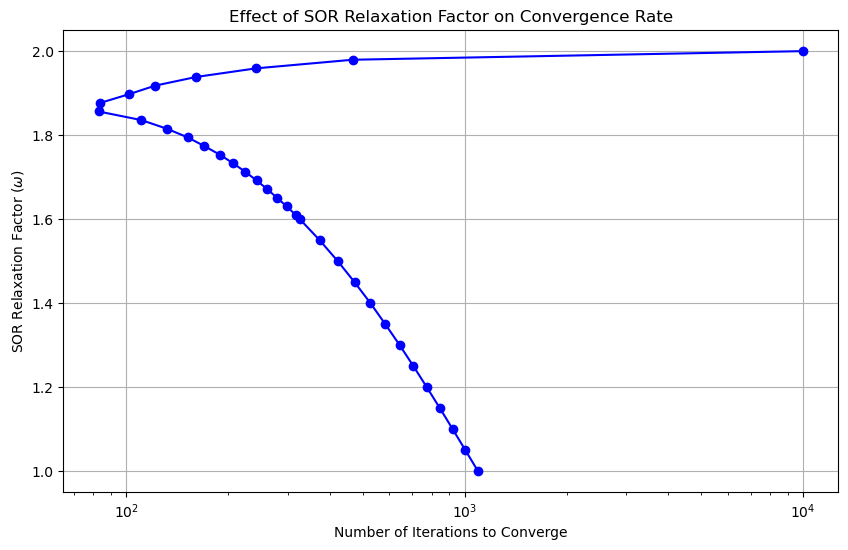

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit

# Constants
L = 1.5  # Length of the duct in meters
h = 1.0  # Height of the duct in meters
mu = 0.4  # Dynamic viscosity in Ns/m^2

# Grid parameters
JM = 41  # Grid points in x direction (along the length)
KM = 41  # Grid points in y direction (across the height)
dx = L / (JM - 1)  # Grid spacing in x-direction
dy = h / (KM - 1)  # Grid spacing in y-direction

# Initialize the grid
def initialize_grid(KM, JM):
    return np.zeros((KM, JM))

@njit
def sor(w, dx, dy, dp_dz, mu, tol, max_iterations, omega):
    KM, JM = w.shape
    for it in range(max_iterations):
        w_old = w.copy()
        for j in range(1, KM - 1):
            for i in range(1, JM - 1):
                w[j, i] = (1 - omega) * w[j, i] + omega * (
                    ((w[j, i + 1] + w[j, i - 1]) * dy**2 +
                     (w[j + 1, i] + w[j - 1, i]) * dx**2 +
                     dx**2 * dy**2 * dp_dz / mu) / (2 * (dx**2 + dy**2)))
        if np.sqrt(np.mean((w - w_old) ** 2)) < tol:
            return it + 1  # Return the number of iterations taken to converge
    return max_iterations

def analytical_solution(y, z, L, h, dp_dz, mu=0.4, terms=100):
    sum_series = np.zeros_like(y)
    for m in range(1, 2 * terms, 2):  # Sum over odd m: 1, 3, 5, ...
        z_factor = m * np.pi * z / (2 * L)
        h_factor = m * np.pi * h / (2 * L)

        # Compute the stable ratio of cosh terms
        if z_factor < h_factor:
            cosh_ratio = np.exp(z_factor - h_factor)
        else:
            cosh_ratio = np.exp(h_factor - z_factor)

        # Compute the series term
        term = ((-1)**((m-1)//2) *
                np.cos(m * np.pi * y / (2 * L)) / m**3) * (1 - cosh_ratio)
        sum_series += term
    return (16 * L**2 * (-dp_dz) / (mu * np.pi**3)) * sum_series

# Solver settings
dp_dz = -10  # Pressure gradient
omega_values = np.concatenate((np.linspace(1.0, 1.6, 13), np.linspace(1.61, 2.0, 20)))  # Range of omega values to test
tol = 0.00001
max_iterations = 10000

# Run simulations for different omega values and record the iterations required
iterations = []
y = np.linspace(-h/2, h/2, KM)  # Centered y-coordinates
W_analytical = analytical_solution(y, L / 2, L, h, dp_dz, mu)

for omega in omega_values:
    # Initialize the grid
    w = initialize_grid(KM, JM)
    
    # Solve using SOR for the given omega
    num_iterations = sor(w, dx, dy, dp_dz, mu, tol, max_iterations, omega)
    iterations.append(num_iterations)
# Find omega with minimum iterations
min_iterations_index = np.argmin(iterations)
optimal_omega = omega_values[min_iterations_index]
print(f'Optimal omega with minimum iterations: {optimal_omega}')

# Plotting omega vs iterations
plt.figure(figsize=(10, 6))
plt.plot(iterations, omega_values,   'o-', color='blue')
plt.xscale('log')  # Use a logarithmic scale for better visualization of the convergence rate
plt.ylabel('SOR Relaxation Factor ($\omega$)')
plt.xlabel('Number of Iterations to Converge')
plt.title('Effect of SOR Relaxation Factor on Convergence Rate')
plt.grid(True)
plt.show()

 